# Statistical inference

## [Scientific Computing with Python](http://scicompy.yoavram.com)
## Yoav Ram

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import urllib.request
import os.path
import zipfile
import pandas as pd
import seaborn as sns
sns.set(
    style='white',
    context='talk'
)
red, blue, green = sns.color_palette('Set1', 3)

# Statistical inference: the frequentist approach

Statistical inference uses scientific models to explain observable phenomena.

Statistical inference applies mathematical and computational methods to draw conclusions on _Models_ from the _Theoretical World_ using  _Data_ from the _Real World_.

![Big picture of statistical inference](../resources/bigpic.png)

**Fig 1. from [Kass 2011](http://www.stat.cmu.edu/~kass/papers/bigpic.pdf).**


The two major approaches to statistical inference (and statistics as a whole) are the **frequentist** and **Bayesian** approaches, but in this course we will use both, in the spirit of [_Statistical pragmatism_](http://www.stat.cmu.edu/~kass/papers/bigpic.pdf).

Today we will deal with the **frequentist approach**.

# Simple model for photon counts

This example follows a [blog post by Jake VanDerPlas](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/).

Imagine that we point our telescope to the sky, and observe a flux of light coming from a single star.

For the time being, we'll assume that the star's _true_ flux is constant with time, i.e. that is it has a fixed value $\mu$.
We'll also ignore effects like sky noise and other sources of systematic error.

We'll assume that we perform a series of $n$ measurements with our telescope, where the $i^{\rm th}$ measurement reports the observed photon flux $X_i$.
We assume that $X_i$ is Poisson-distributed around the real flux $\mu$:
$$
X_i \sim Poi(\mu)
$$

So $Poi(\mu)$ is our **model**, and $\{X_i\}$ is the data.

The question is, given this data $\{X_i\}$, what is our best estimate of the true flux $\mu$?

Generating this estimate is the objective of **statistical inference**: making conclusions on observable phenomea by applying mathematical methods to data and models.

We start by simulating data.

In [2]:
np.random.seed(1)

# true flux: number of photons measured in 1 second
μ = 1000  
# number of measurements
n = 50 
# n measurements of the flux
X = np.random.poisson(μ, size=n)

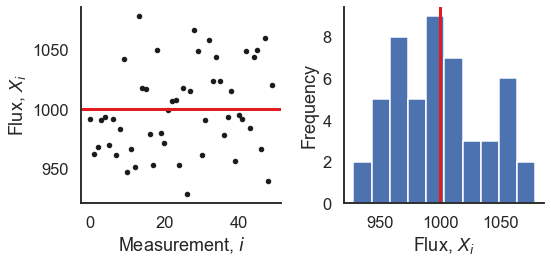

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

ax = axes[0]
ax.plot(np.arange(n), X, '.k')
ax.axhline(μ, linewidth=3, color=red)
ax.set_xlabel("Measurement, $i$")
ax.set_ylabel("Flux, $X_i$")

ax = axes[1]
ax.hist(X, bins=10)
ax.axvline(μ, linewidth=3, alpha=1, color=red)
ax.set_ylabel("Frequency")
ax.set_xlabel("Flux, $X_i$")

fig.tight_layout()
sns.despine()

In this toy example we already know the
true flux $\mu$, but the question is this: **given our measurements $\{X_i\}$, what is our best estimate of the true flux $\mu$?**

## Maximum likelihood

Which mathematical method can we use to make conclusions on $\mu$ from $\{X_i\}$?

Maximum likelihood is a very common and popular approach to statistical inference in which we look for the model that has the maximum probability to generate the observed data.

Formally, the **likelihood $\mathcal{L}$ of the model 
$$
X_i \sim Poi(\mu)
$$
given observed data $\{(X_i)\}_i$ is the probability of seeing data given the model:**
$$
\mathcal{L}(\mu~|~X) = 
\prod_{i=1}^n P(x_i~|~\mu)
$$

We assume (or even know) that the distribution of the measurements $\{X_i\}$ is Poisson.
Therefore, the probability to see $X_i$ given $\mu$ is
$$
P(X_i~|~\mu) = 
\frac{\mu^{X_i} e^{-\mu}}{X_i!}
$$

So the likelihood $\mathcal{L}$ is a product of exponents.
Therefore, we take the log-likelihood $\log\mathcal{L}$:

$$
\log\mathcal{L}(\mu~|~X) = 
\sum_{i=1}^n \log{P(X_i~|~\mu)}
$$

## Exercise 1: log-likelihood

**Implement the `log_likelihood(μ, X)` function** that takes $\mu$, the expected value of a Poisson distribution, and $X$, and array of measurements, and returns $\log\mathcal{L}(\mu~|~X)$, the log-likelihood of $\mu$ given we saw $X$, which equals $\log P(X \mid \mu)$, the log-probability of seeing $X$ if $\mu$ is true.

Then execute the code below to reproduce the plot.

You can check the [solution](../solutions/statistics.ipynb) afterwards.

In [4]:
def log_likelihood(μ, X):
    """
    Gives the log likelihood of μ, conditioned on the data.
    """
    return scipy.stats.poisson.logpmf(X, μ).sum()

Here's a plot of the log-likelihood function, with the true value in red circle and the measured values in black dots.

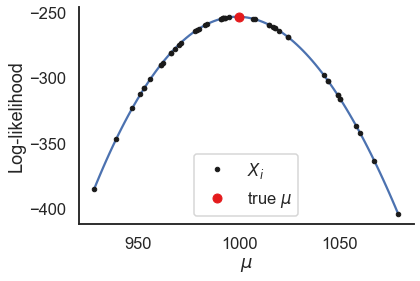

In [5]:
X_range = np.linspace(X.min(), X.max(),100)
plt.plot(X_range, [log_likelihood(x, X) for x in X_range])
plt.plot(X, [log_likelihood(x, X) for x in X], '.k', label='$X_i$')
plt.plot(μ, log_likelihood(μ, X), 'o', color=red, label='true $μ$')
plt.xlabel("$\mu$")
plt.ylabel("Log-likelihood")
plt.legend()
sns.despine()

The flux value $\hat{\mu}$ that maximizes the log-likelihood $\log\mathcal{L}$ will be our **maximum likelihood estimate $\hat{\mu}$**.

We can find this analytically by solving for the root of the derivative of the normal approximation of the log-likelihood:

$$
\frac{d\log\mathcal{L}}{d\hat{\mu}}
\\ =
\frac{d}{d\hat{\mu}} \sum_{i=1}^n{\log{\frac{\hat{\mu}^{X_i} e^{-\hat{\mu}}}{X_i!}}}
\\ =
\frac{d}{d\hat{\mu}} \sum_{i=1}^n{\log{\hat{\mu}^{X_i}} + \log{e^{-\hat{\mu}}} - \log{(X_i!)}}
\\ =
\frac{d}{d\hat{\mu}} \sum_{i=1}^n{X_i \log{\hat{\mu}} -\hat{\mu} - \log{(X_i!)}}
\\ =
\sum_{i=1}^n{\frac{X_i}{\hat{\mu}} - 1}
\\ =
\frac{1}{\hat{\mu}} \sum_{i=1}^n{X_i} - n
$$

So
$$
\frac{d\log\mathcal{L}}{d\hat{\mu}} = 0 \Rightarrow
\hat{\mu} = \frac{1}{n}\sum_{i=1}^n{X_i}
$$
So the estimate $\hat{\mu}$ is the **arithmetic mean** $\bar{X}=\frac{1}{n}\sum_{i=1}^n{X_i}$!

μ = 1000 
μ_hat = 999.04


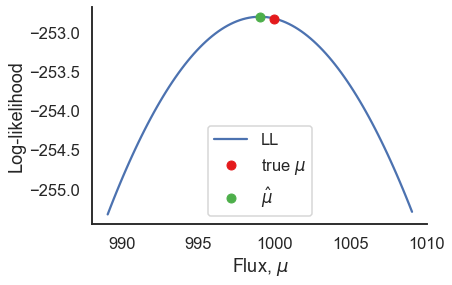

In [6]:
μ_hat = X.mean()
print("μ = {} \nμ_hat = {}".format(μ, μ_hat))

X_range = np.linspace(μ_hat*0.99, μ_hat*1.01, 100)
plt.plot(X_range, [log_likelihood(x, X) for x in X_range], label='LL')
plt.plot(μ, log_likelihood(μ, X), 'o', color=red, label='true $μ$')
plt.plot(μ_hat, log_likelihood(μ_hat, X), 'o', color=green, label='$\hat{μ}$')

plt.xlabel("Flux, $\mu$")
plt.ylabel("Log-likelihood")
plt.legend()
sns.despine()

The [Cramér–Rao bound](https://en.wikipedia.org/wiki/Cramér–Rao_bound) provides a lower bound for the precision of this estimate

$$
var(\hat{\mu}) \ge \frac{1}{\mathcal{I}}
$$

where $\mathcal{I}$ is Fisher information, defined as:
$$
\mathcal{I} = - \mathbf{E}\Big[\frac{d^2\log\mathcal{L}}{d\hat{\mu}^2} \Big]
$$

So, we have
$$
\frac{d\log\mathcal{L}}{d\hat{\mu}} =
\frac{1}{\hat{\mu}} \sum_{i=1}^n{x_i} - n \Rightarrow \\
\frac{d^2\log\mathcal{L}}{d\hat{\mu}^2}  =
-\frac{1}{\hat{\mu}^2} \sum_{i=1}^n{x_i} \Rightarrow \\
\mathcal{I} =
- \mathbf{E}\Big[-\frac{1}{\hat{\mu}^2} \sum_{i=1}^n{x_i} \Big] = 
\frac{1}{\hat{\mu}^2} \mathbf{E}\Big[ \sum_{i=1}^n{x_i} \Big] =
\frac{n}{\hat{\mu}} 
\Rightarrow \\
var(\hat{\mu}) \ge
\frac{\hat{\mu}}{n}  \Rightarrow \\
\sigma_{\hat{\mu}} \ge
\sqrt{\frac{\hat{\mu}}{n}}
$$

μ = 1000 
μ_hat = 999.04 +/- 4.469988814303678


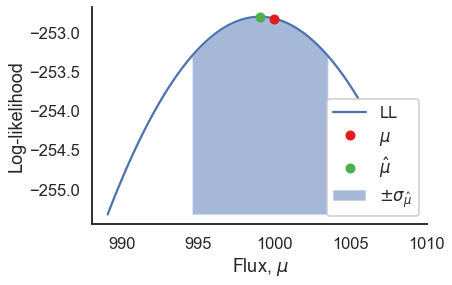

In [7]:
σ_hat = np.sqrt(μ_hat/n)
print("μ = {} \nμ_hat = {} +/- {}".format(
    μ, μ_hat, σ_hat))

X_range = np.linspace(μ_hat*0.99, μ_hat*1.01, 100)
plt.plot(X_range, [log_likelihood(x, X) for x in X_range], label='LL')
plt.plot(μ, log_likelihood(μ, X), 'o', color=red, label='$μ$')
plt.plot(μ_hat, log_likelihood(μ_hat, X), 'o', color=green, label='$\hat{μ}$')

X_range = np.linspace(μ_hat-σ_hat, μ_hat+σ_hat)
plt.fill_between(X_range, log_likelihood(μ_hat*0.99, X), 
                 [log_likelihood(x, X) for x in X_range], 
                 alpha=0.5, label='$\pm \sigma_{\hat{\mu}}$')
plt.xlabel("Flux, $\mu$")
plt.ylabel("Log-likelihood")
plt.legend(loc='lower right', framealpha=1)
sns.despine()

# Complex model for photon count

We now assume that the light source is dynamic and stochastic (e.g. Quasar).

That is, the measurements $\{X_i\}$ are still drawn from a Poisson distribution, but the expected values $F_i$ change over time.
We assume $F_i$ is drawn from a normal distrubtion with expectation $\mu$ and standard deviation $\sigma$:
$$
F_i \sim N(\mu, \sigma) \\
X_i \sim Poi(F_i)
$$

We note the model parameters as $\theta = (\mu, \sigma)$.

Our data is still $\{X_i\}$, but the model is now more _complex_, as it includes a model for the measurements $Poi(F_i)$ and a model for the true flux $N(\mu, \sigma)$.

Let's simulate data according to this complex model.

In [8]:
# for reproducibility
np.random.seed(42)
# we'll use more samples for the complex model
n = 100  
# parameters stochastic flux model
θ = (μ, σ) = 1000, 15
# (unknown) true flux
F = np.random.normal(μ, σ, size=n)
# observed flux: true flux plus Poisson errors
X = np.random.poisson(F)

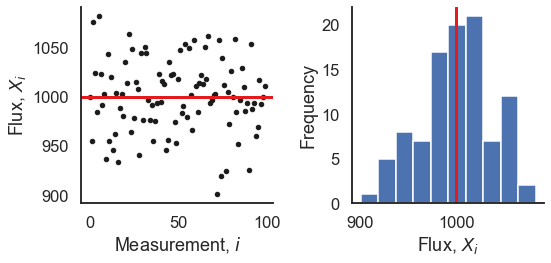

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

ax = axes[0]
ax.plot(np.arange(n), X, '.k')
ax.axhline(μ, linewidth=3, color=red)
ax.set_xlabel("Measurement, $i$")
ax.set_ylabel("Flux, $X_i$")

ax = axes[1]
ax.hist(X, bins=10)
ax.axvline(μ, linewidth=3, alpha=1, color=red)
ax.set_ylabel("Frequency")
ax.set_xlabel("Flux, $X_i$")

fig.tight_layout()
sns.despine()

Here we make use of the normal approximation of the Poisson distribution, which works well for high expected values, so that 
$$
F_i \sim N(\mu, \sigma^2) \\
X_i \sim Poi(F_i) \approx N(F_i, F_i)
$$

This is useful because compounding normal distributions gives a normal distribution with a sum of variances:

$$
X_i \approx N(\mu, \sigma^2 + e_i^2)
$$
where we estimate $e_i^2 \approx X_i$, just like we would estimate $\mu \approx X_i$.

The likelihood function is therefore

$$
\mathcal{L}(\mu, \sigma~|~X) = 
\prod_{i=1}^n \frac{1}{\sqrt{2\pi(\sigma^2 + X_i)}}\exp\Big[\frac{-(X_i - \mu)^2}{2(\sigma^2 + X_i)}\Big]
$$

## Exercise 2: log-likelihood

**Implement `log_likelihood(θ, X)`**, where $\theta = (\mu, \sigma)$ and `X` is the data.

You can check the [solution](../solutions/statistics.ipynb) afterwards.

In [10]:
def log_likelihood(θ, X):
    μ, σ = θ
    return -0.5 * (np.log(2 * np.pi * (σ**2 + X)) + (X - μ) ** 2 / (σ**2 + X)).sum()

log_likelihood(θ, X)

-503.223428772118

To find an analytic solution to the maximum likelihood problem we differentiate and set to zero to get

$$
\hat{\mu} = \frac{\sum_{i=1}^n{\frac{X_i}{\sigma^2 + X_i}}}{\sum_{i=1}^n{\frac{1}{\sigma^2+X_i}}}.
$$

However, we see that the estimate for $\mu$ depends on $\sigma$ (and vice versa) so we cannot use a straightforward analytic method.

Instead, we will use a numerical optimization routine from `scipy.optimize`.



Note that optimization routines usually _minimize_ rather than _maximize_, so we use the negative log-likelihood.

In [11]:
def neg_log_likelihood(θ, X):
    return -log_likelihood(θ, X)

neg_log_likelihood(θ, X)

503.223428772118

In [12]:
θ_guess = (900, 5) # you can try something else
θ_hat = scipy.optimize.fmin(
    func=neg_log_likelihood, 
    x0=θ_guess, 
    args=(X,)
)
μ_hat, σ_hat = θ_hat
print("μ = {} \tμ_hat = {:.2f}\nσ = {}\t\tσ_hat = {:.2f}".format(
    μ, μ_hat, σ, σ_hat))

Optimization terminated successfully.
         Current function value: 502.839505
         Iterations: 58
         Function evaluations: 114
μ = 1000 	μ_hat = 999.23
σ = 15		σ_hat = 19.35


We can plot the log-likelihood surface (since there are only two parameters). We'll also call `fmin` again with `retall=True` to get all the $\theta$ it computed at each iterations and plot them as a path on the log-likelihood surface.

In [13]:
θ_hat, θ_path =scipy.optimize.fmin(
    func=neg_log_likelihood, 
    x0=(2000, 20), 
    args=(X,),
    retall=1
)
θ_path = np.array(θ_path)
θ_hat

Optimization terminated successfully.
         Current function value: 502.839505
         Iterations: 64
         Function evaluations: 120


array([999.22674437,  19.35361925])

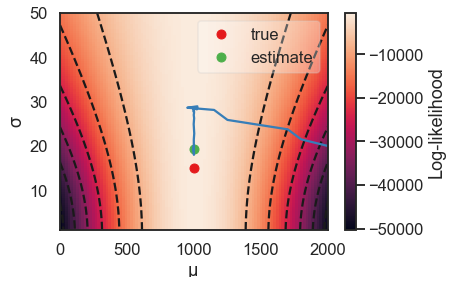

In [14]:
μ_range = np.linspace(0, 2000, 100)
σ_range = np.linspace(1, 50, 101)
ll = np.array([
    [log_likelihood((μ_, σ_), X) for μ_ in μ_range]
    for σ_ in σ_range
])

im = plt.pcolormesh(μ_range, σ_range, ll)
plt.contour(μ_range, σ_range, ll, colors='k')
plt.colorbar(im, label='Log-likelihood')
plt.plot(μ, σ, 'o', color=red, label='true')
plt.plot(μ_hat, σ_hat, 'o', color=green, label='estimate')
plt.plot(θ_path[:,0], θ_path[:,1], '-', color=blue)
plt.xlabel('μ')
plt.ylabel('σ')
plt.legend(framealpha=0.3);

You can see that changing $\sigma$ doesn't have a strong effect on the log-likelihood compared to changing $\mu$. So our $\sigma$ estimate is not as confident as our $\mu$ estimate.

## Bootstrap

How sure are we in our parameter estimates?

There are several analytic methods to quantify the uncertainty in the parameter estimations.

However, we will a computational method: the **bootstrap method**, in which we estimate the parameters from many resamples of the data.

> Bootstrapping is the practice of estimating properties of an estimator (such as its variance) by measuring those properties when sampling from an approximating distribution. One standard choice for an approximating distribution is the empirical distribution function of the observed data. In the case where a set of observations can be assumed to be from an independent and identically distributed population, this can be implemented by constructing a number of resamples with replacement, of the observed data set (and of equal size to the observed data set).

For efficiency, we parallelize this step using `ThreadPoolExecutor` from Python's standard library.

In [15]:
n_resamples = 1000
resamples = np.random.choice(X, size=(n_resamples, n))

In [16]:
from concurrent.futures import ThreadPoolExecutor

In [17]:
def max_log_likelihood(X):
    return scipy.optimize.fmin(
        func=neg_log_likelihood, 
        x0=θ_guess, 
        args=(X,),
        disp=0 # no prints
    )

with ThreadPoolExecutor() as exec:
    θ_bootstrap = list(exec.map(max_log_likelihood, resamples))

In [18]:
θ_bootstrap = np.array(θ_bootstrap)
μ_bootstrap, σ_bootstrap = θ_bootstrap.T

In [19]:
μ_bootstrap.shape, σ_bootstrap.shape, X.shape, resamples.shape

((1000,), (1000,), (100,), (1000, 100))

We can inspect the distributions of the estimations to see how far the true and estimated values are compared to all boostrap estimations.

We do this with a **corner plot** using the [corner](http://corner.readthedocs.io) package.

The diagonal plots show the histogram of the parameter estimated, and the joint plot (bottom left) shows a joint 2D histogram of the parameters.
The contours on the joint plot show standard deviations (of a gaussian) to demonstrate confidence regions.
This demonstrates that the truth (in red) is just on the edge of the confidence region, whereas the estimate (green) is right at the middle.

In [20]:
from corner import corner

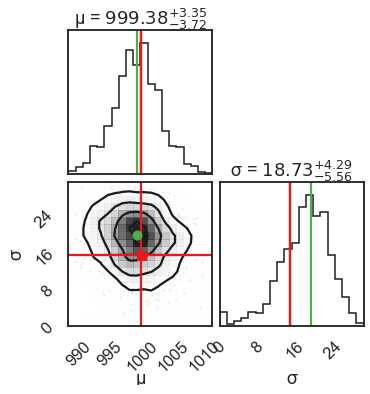

In [24]:
cor = corner(θ_bootstrap, 
    smooth=True,
    labels=['μ', 'σ'],
    truths=[μ, σ],
    truth_color=red,
    show_titles=True,
)
cor.axes[0].axvline(μ, color=red)
cor.axes[3].axvline(σ, color=red)
cor.axes[0].axvline(μ_hat, color=green)
cor.axes[3].axvline(σ_hat, color=green)
cor.axes[2].plot(μ, σ, 'o', color=red)
cor.axes[2].plot(μ_hat, σ_hat, 'o', color=green);

In our next meeting we will learn about the Bayesian approach to inference.

# References

- Jake VanDerPlas's series of [blog posts on Frequentists vs. Bayesian inference](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/)
- Kass, Richard E. [Statistical inference: The big picture](http://www.stat.cmu.edu/~kass/papers/bigpic.pdf). Stat Sci. 2011;26(1):1-9. doi:10.1214/10-STS337

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Scientific Computing with Python_](https://scicompy.yoavram.com/) course at IDC Herzliya.

The notebook was written using [Python](http://python.org/) 3.6.5.
Dependencies listed in [environment.yml](../environment.yml).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)